# Analysis of intervention measures

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
import numpy as np
import seaborn as sns

In [2]:
src = '../data/simulation_results/ensembles'

In [26]:
results = pd.DataFrame()

for f in listdir(src):
    tmp = pd.read_csv(join(src, f))
    results = pd.concat([results, tmp])
    
results = results.reset_index(drop=True)
# subtract the index case
results['infected_agents'] = results['infected_agents'] - 1
results = results.set_index(['unistudent_mask', 'lecturer_mask', 'presence_fraction'])

In [27]:
results['scenario'] = np.nan
results.loc[(0, 0, slice(None)), 'scenario'] = 'no masks'
results.loc[(1, 1, slice(None)), 'scenario'] = 'all masks'
results.loc[(1, 0, slice(None)), 'scenario'] = 'students masks'
results.loc[(0, 1, slice(None)), 'scenario'] = 'lecturers masks'
results = results.reset_index()

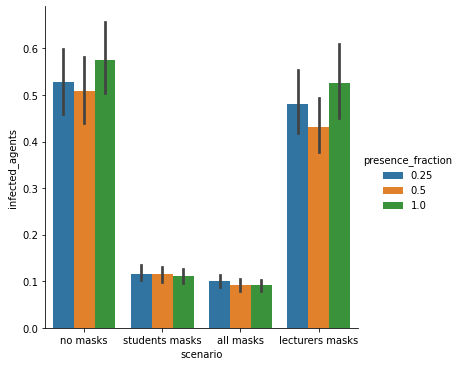

In [28]:
sns.catplot(x='scenario', y='infected_agents',
                hue='presence_fraction',
                data=results, kind="bar")

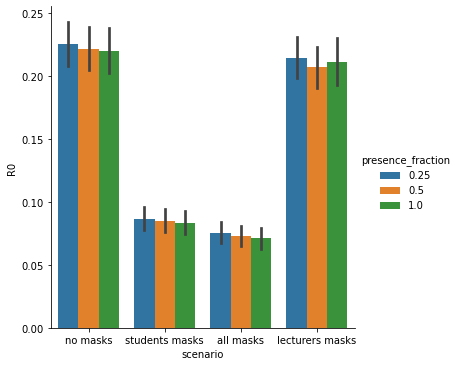

In [29]:
sns.catplot(x='scenario', y='R0',
                hue='presence_fraction',
                data=results, kind="bar")

(array([848.,  94.,  24.,   9.,   5.,   6.,   3.,   1.,   3.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18]),
 <BarContainer object of 9 artists>)

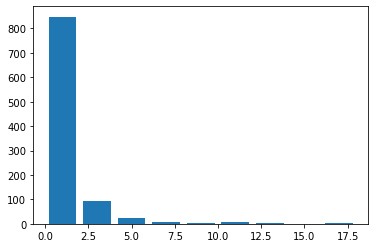

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(results['infected_agents'], bins=range(0, 20, 2), rwidth=0.8)